# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("datasets/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("datasets/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("datasets/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

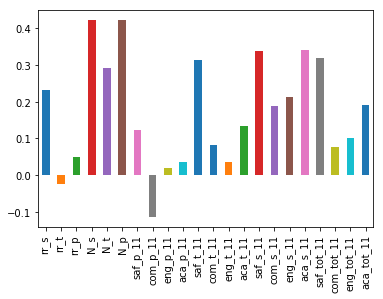

In [13]:
combined.corr()['sat_score'][survey_fields].plot.bar()

Correlation between number of respondents and SAT scores is strongly positive. Which reflects that those who score higher are probably the ones who also are keen to respond to surveys.

Academic expectations from parents and teachers has no correlation to test scores. However, is positively correlated with an r-value of more than 0.3 for students.

Safety and Respect from teachers and students has a positive correlation with SAT scores. Which reflect that respect and safety are considered as high affectors to learning, teaching and thus scoring high in SATs.

The response rate reflects the there is only a correlation between student response ans high SAT scores. Whether parents and teachers respond is not correlating with SAT scores

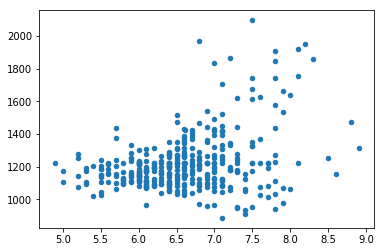

In [14]:
plt.scatter(combined['saf_s_11'], combined['sat_score'], s=20)


The graph shows that safety score less that 7 correlates with low SAT scores. Safety and respect score more that 7 shows a jump in the SAT scores.

/home/fady/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/fady/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/fady/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/fady/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


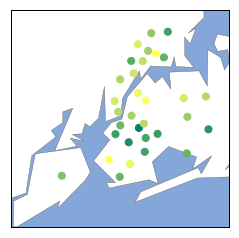

In [15]:
from mpl_toolkits.basemap import Basemap

districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(projection = 'merc',
       llcrnrlat = 40.496044,
       urcrnrlat = 40.915256,
       llcrnrlon = -74.255735,
       urcrnrlon = -73.700272,
       resolution = 'i')

m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawmapboundary(fill_color='#85A6D9')
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

# Racial Comparison

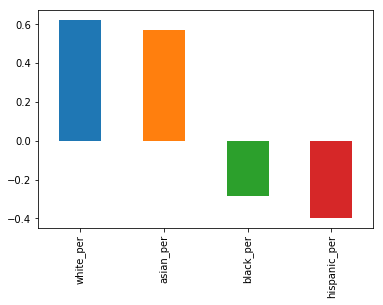

In [16]:
races = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][races].plot.bar()

The SAT scores seems to be negatively correlated with Hispanics and Black students and strongly positively correlated with White and asian students.

This could be a marker for a bias against Black and Hispanic students.

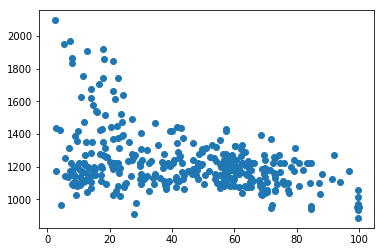

In [17]:
plt.scatter(combined['hispanic_per'], combined['sat_score'])

The plot shows that the SAT scores in a school gets higher the less percentage of hispanics in that school.

In [18]:
sch_95_hisp = combined['SCHOOL NAME'][combined['hispanic_per']>95]
sch_95_hisp

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Those are schools for international, i.e. new immigrant students. As english is newly being learnt, it might impact the performance in SATs

In [19]:
sch_10Hisp_1800SAT = combined['SCHOOL NAME'][(combined['hispanic_per']<10)\
                                             &(combined['sat_score']>1800)]

sch_10Hisp_1800SAT

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Those schools admit only high achieving students according to a  Specialized High Schools Admissions Test.

# Gender Comparison

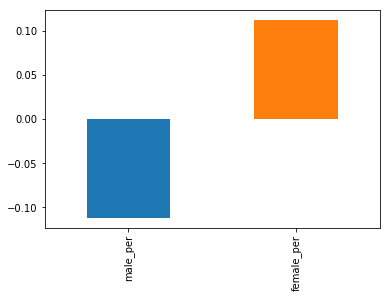

In [20]:
gender = ['male_per', 'female_per']

combined.corr()['sat_score'][gender].plot.bar()

Contrary to common belief, SAT scores are correclating negatively to male test takers and positively to female ones

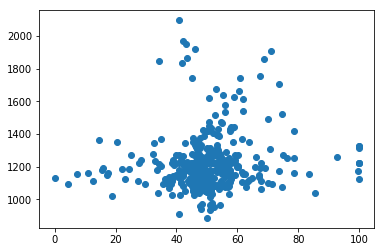

In [21]:
plt.scatter(combined['female_per'],combined['sat_score'])

The scatter plot shows a normal distribution for correlation between SAT scores and the percentage of females in schools.
Between 40-60% it shows a cluster of low scores but a number of ouliers. but on both sides of the range only low SAT scoring.

In [22]:
sch_60f_1700SAT = combined['SCHOOL NAME'][(combined['female_per']>60)&\
                                         (combined['sat_score']>1700)]
sch_60f_1700SAT

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Very selective and high achieveing schools

# Advanced Placement

In [23]:
ap_per = combined['AP Test Takers '] / combined['total_enrollment']

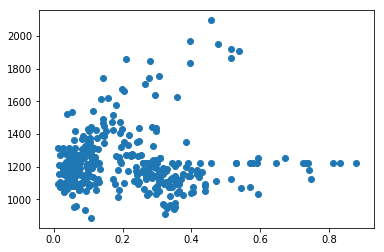

In [24]:
plt.scatter(ap_per, combined['sat_score'])

There exists a linear relationship between the AP scores and SAT scores toll 60%  of AP test taking.
However it is not a strong correlation, since there is a part of the plot that shows no increase in SAT scores with AP test taking.

# Class Size and SAT scores

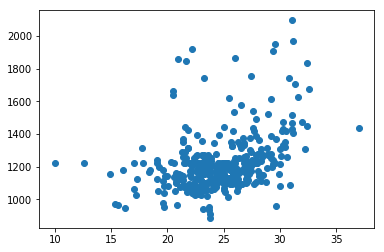

In [25]:
plt.scatter(combined['AVERAGE CLASS SIZE'], combined['sat_score'])

There seems to be a positive correlation between Class size and SAT scores.